In [1]:
# barplot
# https://12jeong.github.io/python-barplot/

# plot color
# https://matplotlib.org/stable/gallery/color/named_colors.html

# 신뢰 구간
# https://angie-gil.medium.com/평점-순으로-정렬하지-않는-법-이론편-9ced2f26bc4b

# cv
# https://coding-potato.tistory.com/15
# https://jimmy-ai.tistory.com/178

# Import Dataset and Libraries

In [2]:
from typing import Any
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore')
plt.rc('font', family='Malgun Gothic')

In [3]:
preprocess_file = "./preprocessing.csv"

drop_columns = [
    'index',
    'date',
#    'round',
#    'game_count',
#    'game_goal',
#    'cur_game_count',
#    'win_odds',
#    'lose_odds',
    'track_E',
#    'cc',
#    'part_people',
#    'rank',
#    'prefix_rank',
    'odds_result',
    'significant',
#    'RESULT',
#    'track_E_encoded',
#    'odds_result_SU',
#    'odds_result_UD',
]

df_pp = pd.read_csv(preprocess_file)
df_pp = df_pp.drop(drop_columns, axis=1)

In [4]:
df_pp.head()

,round,game_count,game_goal,cur_game_count,win_odds,lose_odds,cc,part_people,rank,prefix_rank,RESULT,track_E_encoded,odds_result_SU,odds_result_UD
0,1,3,15,1,4.71,1.27,150,10,10,10,False,41,1,0
1,1,3,15,2,4.71,1.27,150,12,7,17,False,20,1,0
2,2,3,15,1,7.04,1.17,150,11,2,2,True,41,0,1
3,2,3,15,2,7.04,1.17,150,11,5,7,True,0,0,1
4,2,3,15,3,7.04,1.17,150,12,5,12,True,18,0,1


In [5]:
df_pp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   round            620 non-null    int64  
 1   game_count       620 non-null    int64  
 2   game_goal        620 non-null    int64  
 3   cur_game_count   620 non-null    int64  
 4   win_odds         620 non-null    float64
 5   lose_odds        620 non-null    float64
 6   cc               620 non-null    int64  
 7   part_people      620 non-null    int64  
 8   rank             620 non-null    int64  
 9   prefix_rank      620 non-null    int64  
 10  RESULT           620 non-null    bool   
 11  track_E_encoded  620 non-null    int64  
 12  odds_result_SU   620 non-null    int64  
 13  odds_result_UD   620 non-null    int64  
dtypes: bool(1), float64(2), int64(11)
memory usage: 63.7 KB


# Modeling Data Subset

In [6]:
X = df_pp
X, y_rank, y_result = X.drop(['rank', 'RESULT'], axis=1), X['rank'], X['RESULT'].astype(bool)

In [7]:
X.head()

,round,game_count,game_goal,cur_game_count,win_odds,lose_odds,cc,part_people,prefix_rank,track_E_encoded,odds_result_SU,odds_result_UD
0,1,3,15,1,4.71,1.27,150,10,10,41,1,0
1,1,3,15,2,4.71,1.27,150,12,17,20,1,0
2,2,3,15,1,7.04,1.17,150,11,2,41,0,1
3,2,3,15,2,7.04,1.17,150,11,7,0,0,1
4,2,3,15,3,7.04,1.17,150,12,12,18,0,1


# Modeling

In [8]:
!python --version

Python 3.11.5


In [9]:
# !python.exe -m pip install --upgrade pip
# !pip install scikit-learn
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [44]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import hamming_loss
from sklearn.metrics import jaccard_score
from sklearn.base import BaseEstimator

# Classification Model Import
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Regression Model Import
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [59]:
clf_model_dict = {
    "clf_ridge": LogisticRegression(penalty='l2', solver='lbfgs'),
    "clf_lasso": LogisticRegression(penalty='l1', solver='liblinear'),
    "clf_logistic_regression": LogisticRegression(),
    "clf_logistic_regression_": LogisticRegression(solver='liblinear'),
    "clf_adaboost": AdaBoostClassifier(),
    "clf_gradient_boosting": GradientBoostingClassifier(),
    "clf_random_forest": RandomForestClassifier(),
    "clf_xgb": XGBClassifier(),
    "clf_xgb_": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
#     "clf_lgbm": LGBMClassifier(),
#     "clf_catboost": CatBoostClassifier(verbose=0),
    "clf_decision_tree": DecisionTreeClassifier(),
#    "clf_svc": SVC(probability = True),
}

reg_model_dict = {
    "reg_ridge": Ridge(),
    "reg_lasso": Lasso(),
    "reg_linear_regression": LinearRegression(),
    "reg_adaboost": AdaBoostRegressor(),
    "reg_gradient_boosting": GradientBoostingRegressor(),
    "reg_random_forest": RandomForestRegressor(),
    "reg_xgb": XGBRegressor(),
#    "reg_lgbm": LGBMRegressor(),
#    "reg_catboost": CatBoostRegressor(verbose=0),
    "reg_decision_tree": DecisionTreeRegressor(),
    "reg_svr": SVR(),
}

# Training Model

In [12]:
from sklearn.model_selection import train_test_split


def fit_model(
    model: BaseEstimator,
    X: pd.DataFrame,
    y: pd.Series,
    test_size: float = 0.2,
    random_state: int = 42
) -> tuple[BaseEstimator, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size = test_size,
        random_state = random_state
    )
    model.fit(X_train, y_train)
    
    return model, X_train, X_test, y_train, y_test

# Evaluate Model

## Classification

In [13]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)


def eval_clf_model(model: BaseEstimator, X: pd.DataFrame, y: pd.Series) -> tuple[float]:
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y, y_pred)      # 정확도
    precision = precision_score(y, y_pred)    # 정밀도
    recall = recall_score(y, y_pred)          # 재현율
    f1 = f1_score(y, y_pred)                  # F1 점수
    roc_auc = roc_auc_score(y, y_proba)       # ROC-AUC 점수
    
    return accuracy, precision, recall, f1, roc_auc

## Regression

In [14]:
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error
)


def eval_reg_model(model: BaseEstimator, X: pd.DataFrame, y: pd.Series) -> tuple[float]:
    y_pred = model.predict(X)

    r2 = r2_score(y, y_pred)                # R² 점수
    mae = mean_absolute_error(y, y_pred)    # 평균 절대 오차 (MAE)
    mse = mean_squared_error(y, y_pred)     # 평균 제곱 오차 (MSE)
    rmse = mean_squared_error(y, y_pred, squared=False)    # 평균 제곱근 오차 (RMSE)

    return r2, mae, mse, rmse

# K-Fold Cross Validation

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from collections import defaultdict

## Classification

In [16]:
# cross_val_score의 estimator가 classifier 종류이면 내부적으로 stratified KFold 로 진행
def clf_cross_validation(
    model: BaseEstimator,
    X: pd.DataFrame,
    y: pd.Series,
    cv: int = 5
) -> tuple[list[float]]:
    
    # No1 cv
    scores1 = dict()
    scores1['cvs_acc'] = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    scores1['cvs_pre'] = cross_val_score(model, X, y, cv=cv, scoring='precision')
    scores1['cvs_rec'] = cross_val_score(model, X, y, cv=cv, scoring='recall')
    scores1['cvs_f1 '] = cross_val_score(model, X, y, cv=cv, scoring='f1')
    scores1['cvs_roc'] = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

    # No2 cv    
    scores2 = dict()
    skfolds = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    scores2['mix_acc'] = cross_val_score(model, X, y, cv=skfolds, scoring='accuracy')
    scores2['mix_pre'] = cross_val_score(model, X, y, cv=skfolds, scoring='precision')
    scores2['mix_rec'] = cross_val_score(model, X, y, cv=skfolds, scoring='recall')
    scores2['mix_f1 '] = cross_val_score(model, X, y, cv=skfolds, scoring='f1')
    scores2['mix_roc'] = cross_val_score(model, X, y, cv=skfolds, scoring='roc_auc')
    
    # No3 cv
    scores3 = defaultdict(list)
    for fold_idx, (train_idx, val_idx) in enumerate(skfolds.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        scores = eval_clf_model(model, X_val, y_val)
        accuracy, precision, recall, f1, roc_auc = scores
        
        scores3['skf_acc'].append(accuracy)
        scores3['skf_pre'].append(precision)
        scores3['skf_rec'].append(recall)
        scores3['skf_f1 '].append(f1)
        scores3['skf_roc'].append(roc_auc)
    
    return scores1,scores2, scores3

### Print Classification Cross-Validation Score

In [17]:
def print_clf_score(
    model: BaseEstimator,
    scores1: dict,
    scores2: dict,
    scores3: dict
) -> None:
       
    # Scores1: cross_val_score
    for key, value in scores1.items():
        print(f'{key}: {np.mean(value)}')

    # Scores2: StratifiedKFold by cross_val_score
    for key, value in scores2.items():
        print(f'{key}: {np.mean(value)}')

    # Scores3: StratifiedKFold score
    for key, value in scores3.items():
        print(f'{key}: {np.mean(value)}')

## clf 모델 점수 평가

In [60]:
df_clf_scores = pd.DataFrame()
Y = y_result
k = 5

for model_name, model in tqdm(clf_model_dict.items()):
    model, X_train, X_test, y_train, y_test = fit_model(model, X, Y)    
    scores1, scores2, scores3 = clf_cross_validation(
        model,
        X_test,
        y_test,
        k
    )
    
    # print_clf_score(model, scores1, scores2, scores3)
    values = (
        [np.mean(s) for s in scores1.values()] + 
        [np.mean(s) for s in scores2.values()] + 
        [np.mean(s) for s in scores3.values()]
    )    
    
    df_tmp = pd.DataFrame({model_name: values})
    df_clf_scores = pd.concat([df_clf_scores, df_tmp], axis=1)
    
keys = [k for k in scores1.keys()] + [k for k in scores2.keys()] + [k for k in scores3.keys()]
df_clf_scores = pd.concat([df_clf_scores, pd.DataFrame({"name":keys})], axis=1)
df_clf_scores

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.42s/it]


,clf_ridge,clf_lasso,clf_logistic_regression,clf_logistic_regression_,clf_adaboost,clf_gradient_boosting,clf_random_forest,clf_xgb,clf_xgb_,clf_decision_tree,name
0,0.855000,0.855000,0.855000,0.847000,0.863000,1.000000,0.975667,1.000000,1.000000,1.000000,cvs_acc
1,0.828333,0.818095,0.828333,0.810556,0.867063,1.000000,1.000000,1.000000,1.000000,1.000000,cvs_pre
2,0.755556,0.777778,0.755556,0.755556,0.733333,0.977778,0.977778,1.000000,1.000000,0.977778,cvs_rec
3,0.780746,0.788596,0.780746,0.771389,0.792484,0.988235,0.963235,1.000000,1.000000,0.988235,cvs_f1
4,0.917130,0.915926,0.917130,0.921481,0.873333,1.000000,0.998519,1.000000,1.000000,0.988889,cvs_roc
5,0.839000,0.847000,0.839000,0.863000,0.902000,1.000000,0.984000,0.968000,0.968000,0.992000,mix_acc
6,0.793333,0.796494,0.793333,0.816667,0.893333,1.000000,1.000000,0.963636,0.963636,1.000000,mix_pre
7,0.733333,0.755556,0.733333,0.800000,0.844444,1.000000,0.933333,0.955556,0.955556,1.000000,mix_rec
8,0.747268,0.755202,0.747268,0.800826,0.862281,1.000000,0.976471,0.955000,0.955000,1.000000,mix_f1
9,0.900000,0.907037,0.900000,0.914074,0.875370,1.000000,1.000000,0.991667,0.991667,0.988889,mix_roc


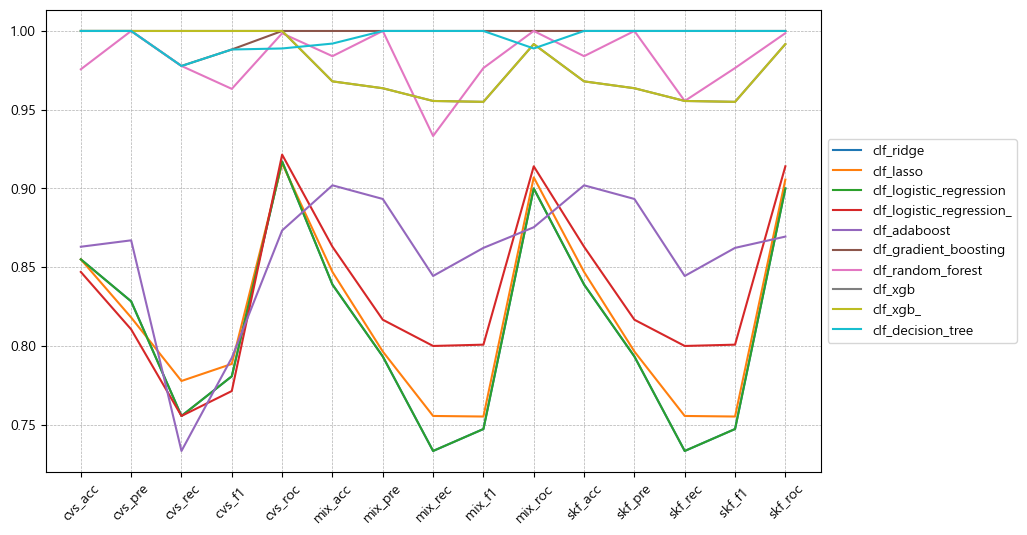

In [61]:
# https://stackoverflow.com/questions/26358200/xticks-by-pandas-plot-rename-with-the-string

df_clf_scores.plot(
    figsize = (10, 6),
    rot = 45
).set_xticks(df_clf_scores.index, df_clf_scores.name)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle='--', linewidth=0.5, axis='x')
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

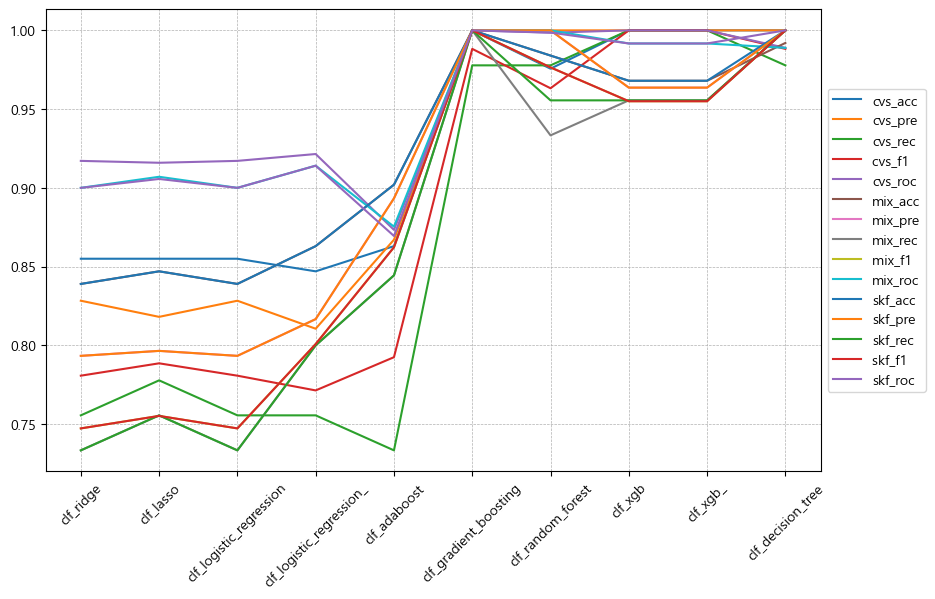

In [92]:
# https://stackoverflow.com/questions/42381639/how-do-i-transpose-dataframe-in-pandas-without-index
# https://stackoverflow.com/questions/20107570/removing-index-column-in-pandas-when-reading-a-csv

df_clf_scores.set_index('name').T.plot(
    figsize = (10, 6),
    rot = 45
).set_xticks(range(10), df_clf_scores.set_index('name').T.index)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle='--', linewidth=0.5, axis='x')
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')



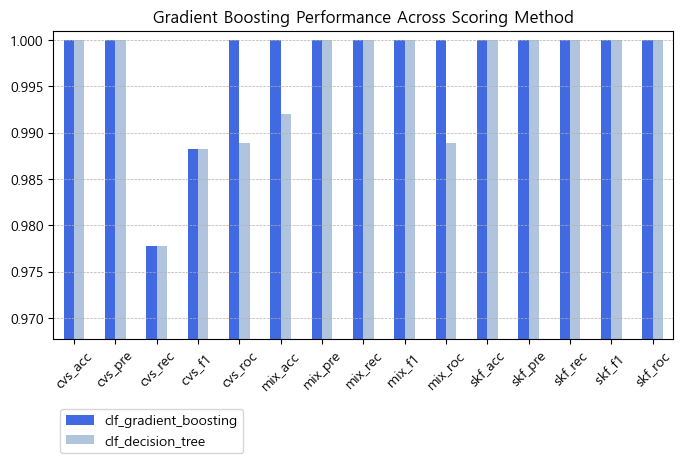

In [65]:
df_tmp = df_clf_scores[["clf_gradient_boosting", "clf_decision_tree", "name"]]

df_tmp.set_index('name').plot.bar(
    figsize = (8, 4),
    title= f"Gradient Boosting Performance Across Scoring Method",
    color = ['royalblue', 'lightsteelblue'],
    xlabel = "",
    ylabel = "",
    ylim = [min(df_tmp["clf_gradient_boosting"])-0.01, max(df_tmp["clf_gradient_boosting"])+0.001],
    rot = 45
)

plt.legend(loc='center left', bbox_to_anchor=(0, -0.3))
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

## Regression

In [22]:
def reg_cross_validation(
    model: BaseEstimator,
    X: pd.DataFrame,
    y: pd.Series,
    cv: int = 5
) -> tuple[list[float]]:
    
    # No1 cv
    scores1 = dict()
    scores1['cvs_r2'] = cross_val_score(model, X, y, cv=cv, scoring='r2')
    scores1['cvs_mae'] = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    scores1['cvs_mse'] = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    scores1['cvs_rmse'] = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')

    # No2 cv    
    scores2 = dict()
    skfolds = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    scores2['mix_r2'] = cross_val_score(model, X, y, cv=skfolds, scoring='r2')
    scores2['mix_mae'] = cross_val_score(model, X, y, cv=skfolds, scoring='neg_mean_absolute_error')
    scores2['mix_mse'] = cross_val_score(model, X, y, cv=skfolds, scoring='neg_mean_squared_error')
    scores2['mix_rmse'] = cross_val_score(model, X, y, cv=skfolds, scoring='neg_root_mean_squared_error')
    
    # No3 cv
    scores3 = defaultdict(list)
    for fold_idx, (train_idx, val_idx) in enumerate(skfolds.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        scores = eval_reg_model(model, X_val, y_val)
        r2, mae, mse, rmse = scores
        
        scores3['skf_r2'].append(r2)
        scores3['skf_mae'].append(mae)
        scores3['skf_mse'].append(mse)
        scores3['skf_rmse'].append(rmse)
    
    return scores1,scores2, scores3

### Print Regression Cross-Validation Score

In [23]:
def print_reg_score(
    model: BaseEstimator,
    scores1: dict(),
    scores2: dict(),
    scores3: dict()
) -> None:    
    # Scores1: cross_val_score
    for key, value in scores1.items():
        print(f'{key}: {np.mean(value)}')

    # Scores2: StratifiedKFold by cross_val_score
    for key, value in scores2.items():
        print(f'{key}: {np.mean(value)}')

    # Scores3: StratifiedKFold score
    for key, value in scores3.items():
        print(f'{key}: {np.mean(value)}')

## reg 모델 점수 평가

In [48]:
df_reg_scores = pd.DataFrame()
Y = y_rank
k = 5

for model_name, model in tqdm(reg_model_dict.items()):
    model, X_train, X_test, y_train, y_test = fit_model(model, X, Y)    
    scores1,scores2, scores3 = reg_cross_validation(
        model,
        X_test,
        y_test,
        k
    )
    
    # print_reg_score(model, scores1, scores2, socres3)
    values = (
        [abs(np.mean(s)) for s in scores1.values()] + 
        [abs(np.mean(s)) for s in scores2.values()] + 
        [abs(np.mean(s)) for s in scores3.values()]
    )    
    
    df_tmp = pd.DataFrame({model_name: values})
    df_reg_scores = pd.concat([df_reg_scores, df_tmp], axis=1)
    
keys = [k for k in scores1.keys()] + [k for k in scores2.keys()] + [k for k in scores3.keys()]
df_reg_scores = pd.concat([df_reg_scores, pd.DataFrame({"name":keys})], axis=1)
df_reg_scores

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.83s/it]


,reg_ridge,reg_lasso,reg_linear_regression,reg_adaboost,reg_gradient_boosting,reg_random_forest,reg_xgb,reg_decision_tree,reg_svr,name
0,0.614289,0.250909,0.609048,0.479768,0.601789,0.590505,0.493479,0.181967,0.071765,cvs_r2
1,1.562399,2.227126,1.577565,1.741271,1.353173,1.346253,1.383360,1.696000,2.785732,cvs_mae
2,3.710655,7.227292,3.750784,5.112472,3.766427,3.712220,4.682221,7.420667,10.299101,cvs_mse
3,1.916674,2.673119,1.928543,2.160487,1.950095,1.959456,2.150116,2.565622,3.199597,cvs_rmse
4,0.640269,0.287628,0.640627,0.599895,0.664338,0.680910,0.651442,0.438011,0.010330,mix_r2
5,1.536753,2.206545,1.537631,1.620197,1.358898,1.237010,1.298506,1.486000,2.760283,mix_mae
6,3.596611,7.139363,3.591675,4.397645,3.437502,3.298921,3.528976,5.786000,10.082599,mix_mse
7,1.890292,2.661309,1.889537,2.105709,1.799298,1.794049,1.837357,2.390504,3.174492,mix_rmse
8,0.640269,0.287628,0.640627,0.589278,0.663312,0.676441,0.651442,0.406297,0.010330,skf_r2
9,1.536753,2.206545,1.537631,1.583522,1.333646,1.250717,1.298506,1.584000,2.760283,skf_mae


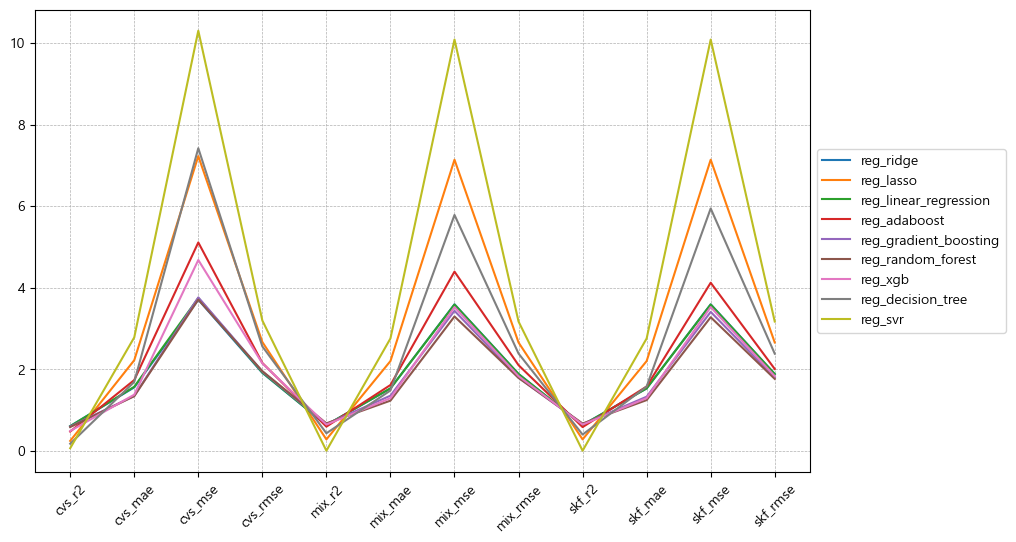

In [49]:
df_reg_scores.plot(
    figsize = (10, 6),
    rot = 45
).set_xticks(df_reg_scores.index, df_reg_scores.name)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle='--', linewidth=0.5, axis='x')
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

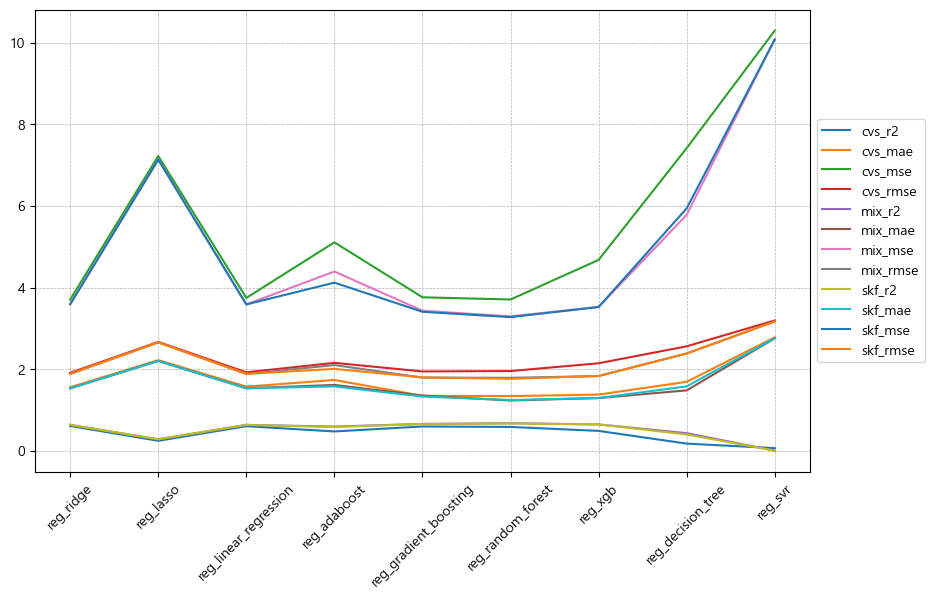

In [50]:
df_reg_scores.set_index('name').T.plot(
    figsize = (10, 6),
    rot = 45
)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle='--', linewidth=0.5, axis='x')
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

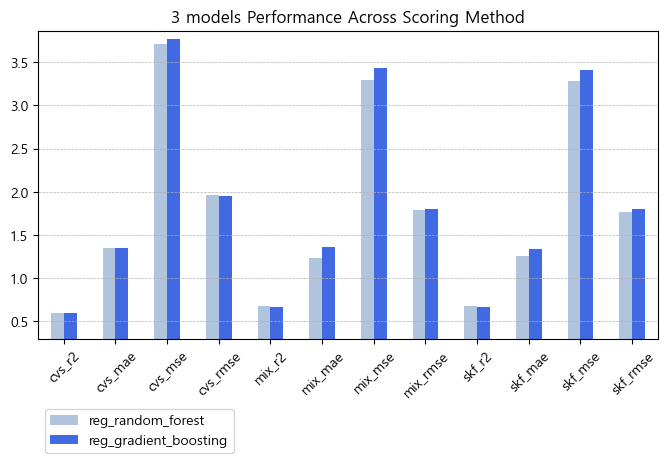

In [51]:
df_tmp = df_reg_scores[[
    "reg_random_forest",
    "reg_gradient_boosting",
    "name"
]]

df_tmp.set_index('name').plot.bar(
    figsize = (8, 4),
    title= f"3 models Performance Across Scoring Method",
    color = ['lightsteelblue', 'royalblue', 'midnightblue', ],
    xlabel = "",
    ylabel = "",
    ylim = [0.3, max(df_tmp["reg_gradient_boosting"])+0.1],
    rot = 45
)

plt.legend(loc='center left', bbox_to_anchor=(0, -0.3))
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

# Test model

In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


def preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    # track_E
    label_encoder = LabelEncoder()
    encoded = label_encoder.fit_transform(df['track_E'])
    df['track_E_encoded'] = encoded
    
    # odds_result
    df['odds_result'] = df['odds_result'].replace("straight up", "SU").replace("underdog", "UD")
    encoder = OneHotEncoder(sparse=False)
    encoded = encoder.fit_transform(df[['odds_result']])
    df_encoded = pd.DataFrame(encoded.astype(int), columns=encoder.get_feature_names_out())
    df = pd.concat([df.reset_index(), df_encoded], axis=1)
    
    return df

In [94]:
drop_columns = [
     'level_0',
     'index',
     'date',
#     'round',
#     'game_count',
#     'game_goal',
#     'cur_game_count',
#     'win_odds',
#     'lose_odds',
     'track_K',
     'track_E',
#     'cc',
#     'part_people',
     'rank',
#     'prefix_rank',
     'odds_result',
     'significant',
     'RESULT',
#     'track_E_encoded',
#     'odds_result_SU',
#     'odds_result_UD',
]

df_test = pd.read_csv("./data/test240227.csv")
df_test = preprocessing(df_test)
df_test_X, df_test_y_result, df_test_y_rank = (
    df_test.drop(drop_columns, axis=1),
    df_test['RESULT'],
    df_test['rank']
)

pp_clf_model1 = clf_model_dict['clf_gradient_boosting'].fit(X, y_result)
pp_clf_model2 = clf_model_dict['clf_decision_tree'].fit(X, y_result)
y_pred1 = pp_clf_model1.predict_proba(df_test_X)
y_pred2 = pp_clf_model2.predict_proba(df_test_X)
# accuracy = accuracy_score(df_test_y_result, y_pred)
for g, d, y in zip(y_pred1, y_pred2, df_test_y_result):
    print(g, d, "--", y)

pp_reg_model1 = reg_model_dict['reg_random_forest'].fit(X, y_rank)
pp_reg_model2 = reg_model_dict['reg_gradient_boosting'].fit(X, y_rank)
y_pred1 = pp_reg_model1.predict(df_test_X)
y_pred2 = pp_reg_model2.predict(df_test_X)
# accuracy = mean_absolute_error(df_test_y_rank, y_pred)
for r, g, y in zip(y_pred1, y_pred2, df_test_y_rank):
    print(int(r), int(g), "--", y)

[9.99184784e-01 8.15216069e-04] [1. 0.] -- False
[9.99563189e-01 4.36810641e-04] [1. 0.] -- False
[9.99184784e-01 8.15216069e-04] [1. 0.] -- False
[0.9989516 0.0010484] [1. 0.] -- False
[0.98352106 0.01647894] [1. 0.] -- False
[0.98640986 0.01359014] [1. 0.] -- False
[0.99250791 0.00749209] [1. 0.] -- False
[9.99091057e-01 9.08943115e-04] [1. 0.] -- False
[9.99184784e-01 8.15216069e-04] [1. 0.] -- False
[0.98487168 0.01512832] [1. 0.] -- False
[0.98640986 0.01359014] [1. 0.] -- False
[0.98199984 0.01800016] [1. 0.] -- False
[0.98640986 0.01359014] [1. 0.] -- False
[0.99250791 0.00749209] [1. 0.] -- False
[9.99005696e-01 9.94303697e-04] [1. 0.] -- False
[9.99184784e-01 8.15216069e-04] [1. 0.] -- False
[0.9804808 0.0195192] [1. 0.] -- False
[0.98245892 0.01754108] [1. 0.] -- False
[0.97707297 0.02292703] [1. 0.] -- False
[0.97424921 0.02575079] [1. 0.] -- False
[0.98245892 0.01754108] [1. 0.] -- False
[0.98103338 0.01896662] [1. 0.] -- False
[0.97197724 0.02802276] [1. 0.] -- False
[0.98

## Classification

In [30]:
# columns_name = [
#     'game_count',
#     'game_goal',
#     'cur_game_count',
#     'cc',
#     'part_people',
#     'track_E_encoded',
# ]

# new_data = [
#     1,    # 'game_count'
#     12,   # 'game_goal'
#     2,    # 'cur_game_count'
#     150,  # 'cc'
#     12,   # 'part_people'
#     71,  # 'track_E_encoded'
# ]

# df = pd.DataFrame([new_data], columns=columns_name)
# proba = rank_model.predict(df)
# f'{proba[0]:.0f}등'

## Regression

In [31]:
# columns_name = [
#     'game_count',
#     'game_goal',
#     'cur_game_count',
#     'cc',
#     'part_people',
#     'track_E_encoded',
# ]

# new_data = [
#     1,    # 'game_count'
#     12,   # 'game_goal'
#     2,    # 'cur_game_count'
#     150,  # 'cc'
#     12,   # 'part_people'
#     71,  # 'track_E_encoded'
# ]

# df = pd.DataFrame([new_data], columns=columns_name)
# proba = result_model.predict_proba(df)
# f, t = proba.flatten()

# print(f"True  probability: {t}")
# print(f"False probability: {f}")

# Hyperparameter Tuning

In [32]:
# https://velog.io/@hyunicecream/GridSearchCV%EB%9E%80-%EC%96%B4%EB%96%BB%EA%B2%8C-%EC%82%AC%EC%9A%A9%ED%95%A0%EA%B9%8C


def hyper_tuning():
    # No5 cv
    param_grid = {
        "C": [0.1, 1, 10, 100],
    }
    grid_search = GridSearchCV(model, param_grid, cv = 5)
    grid_search.fit(X, y)
    
    return grid_search.best_params_, grid_search.best_score_